# **RQ3: How does the interaction change the covered solution space?**

# **TRAIN TICKET Case Study**

This is both about the search space and the objective space.
Is the solution space only about quality attributes? or is it a wider notion?

Indicators (for objective space):
*   Quality-attribute objectives such as: perfQ and reliability, or others. If a 4D space is considered, the visualization might require a PCA (or similar) kind of projection.
*   Types of clusters (or discretization ranges) identified across the objective space.
*   Coverage of the quality-attribute space (e.g., density), beyond the Pareto frontier.

Indicators (for search space):
*   Paths covered by each search tree, based on the reference space (tree).





In [1]:
#!pip install altair --quiet
#!pip install pca --quiet
#!pip install zss --quiet
#!pip install pymoo --quiet 
##!pip install dataframe_image --quiet
#!pip install distinctipy --quiet
##!pip install fastDamerauLevenshtein --quiet
#!pip install opentsne --quiet
#!pip install yellowbrick --quiet
#!pip install plotly --quiet
#!pip install networkx --quiet
#!pip install pydot --quiet
#!pip install matplotlib_venn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
#import dataframe_image as dfi
from PIL import Image
import networkx as nx
import seaborn as sns
#import imgkit

In [3]:
# This is the class that imports all the functions needed for the analysis
from architecturespaceanalyzer import ArchitectureSpaceAnalyzer 

---

## **File downloads and Parsing**

In [4]:
# This is the reference Pareto front/space
NSGAII_PROJECT_NAME = 'nsgaii-train-ticket-1000-eval'
NSGAII_DATAPATH = './zips/'+ NSGAII_PROJECT_NAME +'.zip' 

### *Non-interactive run*

In [5]:
# This is the non-interactive run (100 eval, length 4)
# ttbs-baseline-100-eval 
NSGAII_IT0_100_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-100-eval-it-0'
NSGAII_IT0_100_DATAPATH = './zips/'+ NSGAII_IT0_100_PROJECT_NAME +'.zip' 

### _Interactive runs_

In [6]:
# ttbs 1st step of 50 eval, length 2
NSGAII_IT0_50_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-0-l-2'
NSGAII_IT0_50_DATAPATH = './zips/'+ NSGAII_IT0_50_PROJECT_NAME +'.zip' 

In [7]:
# ttbs 2nd step of 50 eval, length 2 (using centroid)
NSGAII_IT1_50_C258_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258'
NSGAII_IT1_50_C258_DATAPATH = './zips/'+ NSGAII_IT1_50_C258_PROJECT_NAME +'.zip' 

In [8]:
# ttbs 2nd step without pas with 50 eval, length 2
NSGAII_IT1_50_C258_NO_PAS_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258-no-pas'
NSGAII_IT1_50_C258_NO_PAS_DATAPATH = './zips/'+ NSGAII_IT1_50_C258_NO_PAS_PROJECT_NAME +'.zip' 

In [9]:
# ttbs 2nd step of 50 eval, length 2 (using centroid 223)
NSGAII_IT1_50_C223_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223'
NSGAII_IT1_50_C223_DATAPATH = './zips/'+ NSGAII_IT1_50_C223_PROJECT_NAME +'.zip' 

In [10]:
%%capture
!unzip -o $NSGAII_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_100_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_50_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C258_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C258_NO_PAS_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C223_DATAPATH -d datasets

In [11]:
#!rm -r 'datasets'

In [12]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 70})

# **ANALYSIS OF QUALITY ATTRIBUTES**

In [13]:
ALL_CLUSTER_LABELS = ['slow / reliable / few / average',
 'slow / minimally-reliable / very-few / very-few',
 'very-slow / average / very-few / very-few',
 'slow / average / few / few',
 'very-slow / reliable / very-few / few',
 'very-slow / very-reliable / very-few / very-few',
 'slow / very-reliable / few / average',
 'slow / very-reliable / very-few / average',
 'slow / reliable / average / few',
 'slow / reliable / few / few',
 'slow / average / very-few / few',
 'slow / very-reliable / few / few',
 'very-slow / minimally-reliable / few / very-few',
 'slow / very-reliable / very-few / few',
 'slow / reliable / many / many',
 'slow / unreliable / few / very-few',
 'slow / very-reliable / very-few / very-few',
 'slow / minimally-reliable / average / very-few',
 'very-slow / reliable / few / few',
 'slow / average / some / very-few',
 'slow / minimally-reliable / very-few / few',
 'slow / reliable / very-few / few',
 'very-slow / reliable / few / very-few',
 'slow / average / very-few / very-few',
 'slow / reliable / few / very-few',
 'very-slow / average / few / very-few',
 'slow / minimally-reliable / few / very-few',
 'slow / minimally-reliable / some / very-few',
 'slow / average / few / very-few',
 'very-slow / reliable / very-few / very-few',
 'very-slow / very-reliable / few / few',
 'slow / average / average / few',
 'slow / reliable / average / very-few',
 'slow / reliable / very-few / very-few',
 'slow / unreliable / very-few / very-few',
 'very-slow / minimally-reliable / very-few / very-few']

#PROBLEM_OBJECTIVES = OBJS_PERFQ_RELIABILITY + ['#changes', 'pas']

# Global (common) ranges for the 2 objectives
CHANGES_LIMITS = (2.5,50)
PAS_LIMITS = (0,14)

In [14]:
from sklearn.preprocessing import LabelEncoder

LE_ALL_CLUSTER_LABELS = LabelEncoder().fit(ALL_CLUSTER_LABELS)

def show_tradeoffs_pca(space, pca=None, title=None):
  clabels = LE_ALL_CLUSTER_LABELS.transform(space.tagged_objectives_df['label'])
  pca_ = space.show_clusters_pca_2d(cluster_labels=clabels, palette=list(space.LABELS_COLORS.values()), pca=pca, title=title)
  return pca_

def show_tradeoffs_tsne(space, tsne=None, title=None):
  clabels = LE_ALL_CLUSTER_LABELS.transform(space.tagged_objectives_df['label'])
  tsne_ = space.show_clusters_tsne(cluster_labels=clabels, palette=list(space.LABELS_COLORS.values()), tsne=tsne, title=title)
  return tsne_


---
## **Reference Pareto Front (1000)**

In [15]:
# Initialize the project/file
ref1000_space = ArchitectureSpaceAnalyzer()
ref1000_space.initialize_dataset(NSGAII_PROJECT_NAME)
print(ref1000_space.PROJECT_NAME)

ref1000_space.set_labels(ALL_CLUSTER_LABELS)
ref1000_space.CHANGES_LIMITS = CHANGES_LIMITS
ref1000_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = ref1000_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-train-ticket-1000-eval
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-1000-eval
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [16]:
# This the global palette for all cluster labels
print(len(ref1000_space.CLUSTERS_COLORS))
sns.color_palette(ref1000_space.CLUSTERS_COLORS)

36


[(0.0, 1.0, 0.0),
 (1.0, 0.0, 1.0),
 (0.0, 0.5019607843137255, 1.0),
 (1.0, 0.5019607843137255, 0.0),
 (0.5019607843137255, 0.7490196078431373, 0.5019607843137255),
 (0.34509803921568627, 0.0, 0.6470588235294118),
 (0.7411764705882353, 0.00784313725490196, 0.047058823529411764),
 (0.2, 0.4980392156862745, 0.00784313725490196),
 (0.7411764705882353, 0.4745098039215686, 0.9921568627450981),
 (0.984313725490196, 0.9921568627450981, 0.25882352941176473),
 (0.0, 1.0, 1.0),
 (0.0, 1.0, 0.5019607843137255),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.7529411764705882, 0.25882352941176473, 0.5098039215686274),
 (0.0, 0.0, 1.0),
 (0.5372549019607843, 0.8627450980392157, 0.00784313725490196),
 (0.5294117647058824, 0.9607843137254902, 0.9764705882352941),
 (0.9333333333333333, 0.7058823529411765, 0.6274509803921569),
 (0.396078431372549, 0.4235294117647059, 0.7215686274509804),
 (0.2901960784313726, 0.19607843137254902, 0.21176470588235294),
 (0.5450980392156862, 0.13333333333333333, 0.996078431372549),
 (0.6392156862745098, 0.3607843137254902, 0.03137254901960784),
 (1.0, 0.0, 0.5019607843137255),
 (0.21568627450980393, 0.7215686274509804, 0.7725490196078432),
 (0.03529411764705882, 0.7215686274509804, 0.2235294117647059),
 (0.047058823529411764, 0.23529411764705882, 0.7294117647058823),
 (0.7333333333333333, 0.6431372549019608, 0.19215686274509805),
 (0.7137254901960784, 0.9803921568627451, 0.592156862745098),
 (0.3843137254901961, 0.9921568627450981, 0.3058823529411765),
 (0.984313725490196, 0.24313725490196078, 0.20784313725490197),
 (0.43529411764705883, 0.45098039215686275, 0.3215686274509804),
 (0.03529411764705882, 0.011764705882352941, 0.43529411764705883),
 (0.9725490196078431, 0.30980392156862746, 0.8274509803921568),
 (0.6392156862745098, 0.7333333333333333, 0.8431372549019608),
 (0.7176470588235294, 0.023529411764705882, 0.7215686274509804),
 (0.592156862745098, 0.00392156862745098, 0.3803921568627451)]

In [17]:
ref1000_space.objectives_df.head()

,solID,perfQ,reliability,#changes,pas
0,193,0.145989,0.872976,5.80,3.0
1,305,0.323642,0.811052,5.80,2.0
2,10436,0.311507,0.425184,6.18,0.0
3,27162,0.353116,0.432430,11.74,1.0
4,27194,0.311507,0.425184,6.18,0.0


Statistics for the 4 objectives.

In [18]:
ref1000_space.objectives_df.describe()

,solID,perfQ,reliability,#changes,pas
count,495.000000,495.000000,495.000000,495.000000,495.000000
mean,22263.886869,0.235210,0.710827,8.542727,1.595960
std,9221.509410,0.081578,0.176337,4.865854,1.279859
min,193.000000,-0.003535,0.226731,5.800000,0.000000
25%,19089.500000,0.155849,0.583569,5.990000,1.000000
50%,27392.000000,0.242492,0.789663,6.180000,1.000000
75%,28502.000000,0.311566,0.846598,11.740000,2.000000
max,28967.000000,0.364878,0.904348,48.450000,14.000000


In [19]:
#ref1000_space.refactions_df.head()

### *Metrics*

In [20]:
ref1000_pf = ref1000_space.get_pareto_front()
ref1000_norm_pf = ref1000_space.compute_pareto_front()

# Look only at some of the metrics (NPS, HV, DE)
metrics1000_dict = ref1000_space.compute_all_metrics(ref_point=(1,1,1,1), reference_front=ref1000_norm_pf)
metrics1000_dict['point'] = 'reference'
print("Pareto front metrics for the 4 objectives")
print(metrics1000_dict)
print('\tNPS', metrics1000_dict['NPS'], 'solutions')
print('\tHV', metrics1000_dict['HV'])
print('\tDE', metrics1000_dict['DE'])

ref1000_pf.head()

Pareto front metrics for the 4 objectives
{'C_AB': 0.8208955223880597, 'C_BA': 0.208955223880597, 'IGDPlus': 0.18564444171699163, 'HV': 0.8817306227755024, 'NPS': 201, 'NSolutions': 249, 'NSequences': 492, 'DE': 0.41044997233311453, 'point': 'reference'}
	NPS 201 solutions
	HV 0.8817306227755024
	DE 0.41044997233311453


,perfQ,reliability,#changes,pas
0,0.213003,0.661552,6.18,0.0
1,0.264811,0.525631,6.18,0.0
2,0.300373,0.461310,6.18,0.0
3,0.290337,0.460717,6.18,0.0
4,0.215149,0.532165,6.18,0.0


### *Clustering*
This is not strictly needed for the RQ, but it is for computing the scatter plot below.

In [21]:
# Try k-Means
#labels, _, silhouette = ref1000_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = ref1000_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
ref1000_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [3 2 1 1 1 3 4 2 3 0 1 1 1 1 3 2 2 2 1 3 3 1 3 3 1 2 2 1 3 2 3 3 2 2 3 2 3
 3 3 2 3 2 3 3 3 3 3 3 2 3 0 1 1 1 4 3 2 3 1 3 2 2 2 3 2 3 4 0 4 3 0 2 2 0
 3 2 2 2 3 2 3 4 2 1 1 1 1 1 4 1 1 1 4 1 3 2 2 2 3 2 4 3 3 3 3 1 2 1 2 3 3
 3 2 3 1 1 1 1 1 1 3 3 1 1 3 2 3 2 2 1 1 1 1 1 1 1 3 1 3 3 3 2 3 3 2 2 1 3
 1 1 1 4 3 3 2 3 1 2 2 1 2 2 1 3 3 3 1 1 3 3 2 2 3 1 2 2 3 2 2 2 3 2 2 3 2
 2 3 3 3 3 2 3 2 3 2 3 2 2 3 2 3 2 2 3 2 2 3 3 3 2 1 2 1 3 4 1 0 2 3 1 2 3
 2 3 2 1 3 1 1 1 1 1 1 0 1 0 0 4 1 1 3 2 1 0 2 3 1 2 2 1 1 2 2 2 3 3 2 2 2
 3 2 3 3 3 2 3 3 2 2 3 3 3 3 2 1 1 1 1 3 3 3 2 1 1 2 3 3 2 2 2 2 3 3 2 3 3
 2 3 3 3 3 2 3 3 3 2 1 1 3 1 3 3 1 1 2 2 3 2 3 3 2 1 3 1 1 1 3 3 3 1 1 2 2
 3 2 3 2 2 2 1 3 3 1 1 2 3 2 3 3 3 2 3 2 2 2 3 3 3 2 2 2 2 3 3 3 3 2 3 2 3
 2 1 3 1 3 0 2 2 3 2 1 3 3 2 2 2 3 2 3 3 3 3 2 2 2 2 3 2 3 3 2 3 3 3 3 3 3
 3 2 2 3 2 3 3 3 3 2 1 1 3 3 3 1 3 2 3 2 3 2 2 2 2 2 3 1 1 3 2 3 1 3 2 2 3
 3 2 3 2 2 3 2 3 2 3 2 3 2 3 3 2 3 3 3 2 3 1 1 1 4 1 3 

,perfQ,reliability,#changes,pas,cluster,label
67,0.205996,0.843599,17.59,7.0,0,slow / reliable / few / average
282,0.190688,0.544536,10.88,0.0,1,slow / average / very-few / very-few
392,0.316623,0.714161,6.18,1.0,2,slow / reliable / very-few / very-few
223,0.153165,0.844112,6.81,2.0,3,slow / reliable / very-few / very-few
81,0.364878,0.226731,25.47,2.0,4,slow / minimally-reliable / average / very-few


In [22]:
# Graphical representations of objectives in 2D space
ref1000_space.show_objective_space()
#ref1000_space.show_petal_plot(labels=True, size=(20,5))

Configuring (real) cluster centroids as prototypes ... [9, 371, 481, 164, 92]


alt.HConcatChart(...)

In [23]:
ref1000_space.clusters_info()

  cluster 3 : 199 items 40.20 % slow / reliable / very-few / very-few
  cluster 2 : 163 items 32.93 % slow / reliable / very-few / very-few
  cluster 1 : 110 items 22.22 % slow / average / very-few / very-few
  cluster 4 : 12 items 2.42 % slow / minimally-reliable / average / very-few
  cluster 0 : 11 items 2.22 % slow / reliable / few / average


In [24]:
ref1000_space.describe_cluster_labels()

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


,objective,min,max,unit,label
0,perfQ,-0.10,0.14,unit,very-slow
1,perfQ,0.14,0.38,unit,slow
2,perfQ,0.38,0.62,unit,average
3,perfQ,0.62,0.86,unit,fast
4,perfQ,0.86,1.10,unit,very-fast
5,#changes,2.40,11.94,unit,very-few
6,#changes,11.94,21.48,unit,few
7,#changes,21.48,31.02,unit,average
8,#changes,31.02,40.56,unit,some
9,#changes,40.56,50.10,unit,many


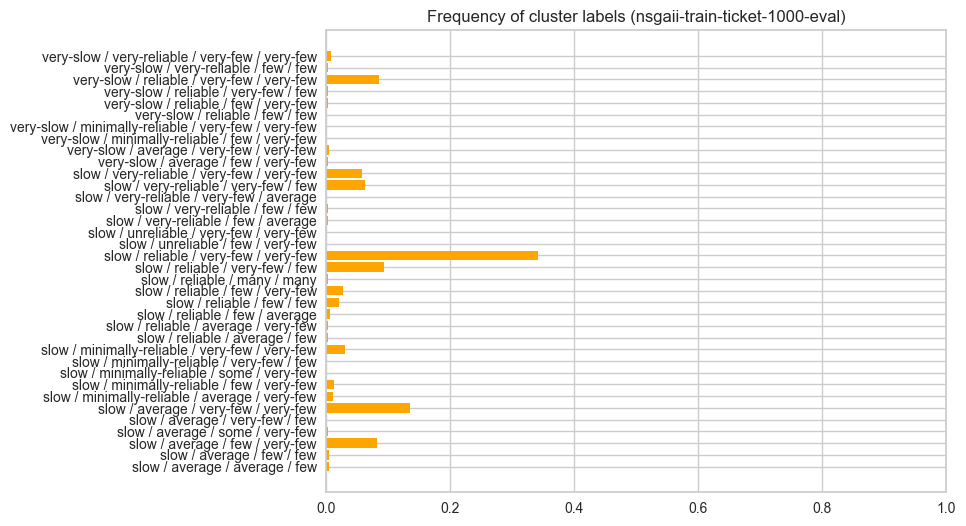

{'slow / average / average / few': 0.00404040404040404,
 'slow / average / few / few': 0.00404040404040404,
 'slow / average / few / very-few': 0.08080808080808081,
 'slow / average / some / very-few': 0.00202020202020202,
 'slow / average / very-few / few': 0.0,
 'slow / average / very-few / very-few': 0.13535353535353536,
 'slow / minimally-reliable / average / very-few': 0.010101010101010102,
 'slow / minimally-reliable / few / very-few': 0.012121212121212121,
 'slow / minimally-reliable / some / very-few': 0.0,
 'slow / minimally-reliable / very-few / few': 0.0,
 'slow / minimally-reliable / very-few / very-few': 0.030303030303030304,
 'slow / reliable / average / few': 0.00202020202020202,
 'slow / reliable / average / very-few': 0.00202020202020202,
 'slow / reliable / few / average': 0.006060606060606061,
 'slow / reliable / few / few': 0.020202020202020204,
 'slow / reliable / few / very-few': 0.026262626262626262,
 'slow / reliable / many / many': 0.00202020202020202,
 'slow /

In [25]:
ref1000_space.show_cluster_labels_distribution(size=(8,6))

### *Visualizations (density)*

PCA components: 2 [0.48259393 0.27438249]


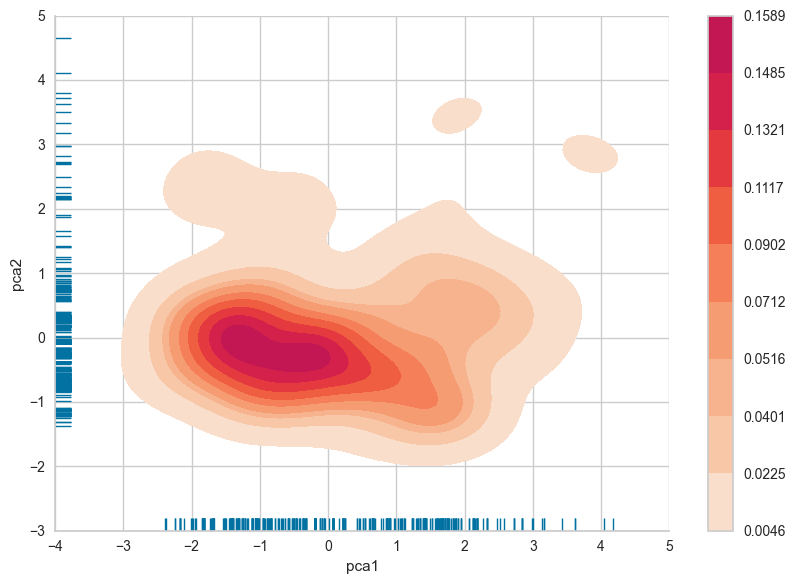

In [26]:
# Density plots for the 2D space of changes versus pas
pca_ref1000 = ref1000_space.show_density_plot(normalize=False, bins=10, pca=True, title='', xlim=(-4,5), ylim=(-3,5), vminmax=(0.004,0.29)) 
#ref1000_space.show_density_plot(kind='bins', normalize=True, bins=10, pca=True)

In [27]:
# Entropy of 4D space
de_4D = ref1000_space.compute_density_entropy(normalize=True, bins=5)
print("The density entropy is:", de_4D)

The density entropy is: 0.391941484404917


Reusing PCA
4 features ['perfQ', 'reliability', '#changes', 'pas']
27 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:688: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



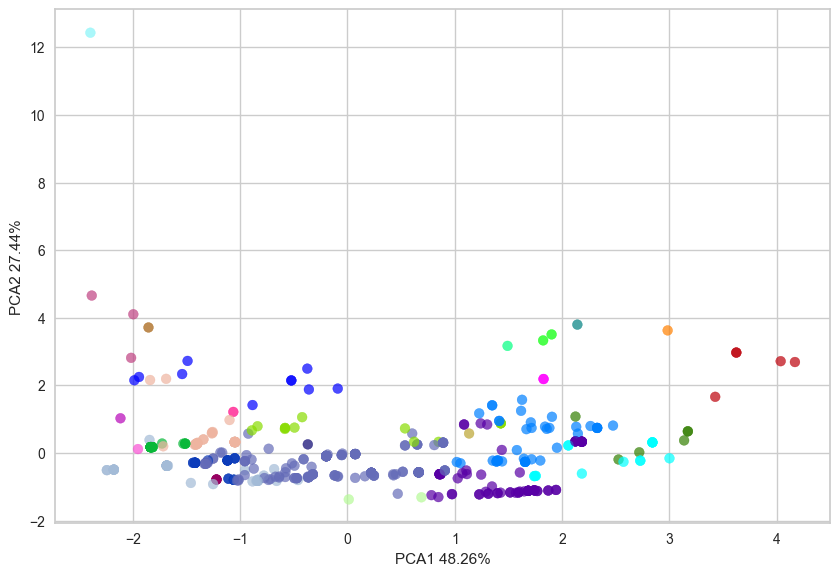

PCA(n_components=2)

In [28]:
show_tradeoffs_pca(ref1000_space, pca=pca_ref1000, title='')

4 features ['perfQ', 'reliability', '#changes', 'pas']
27 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:655: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



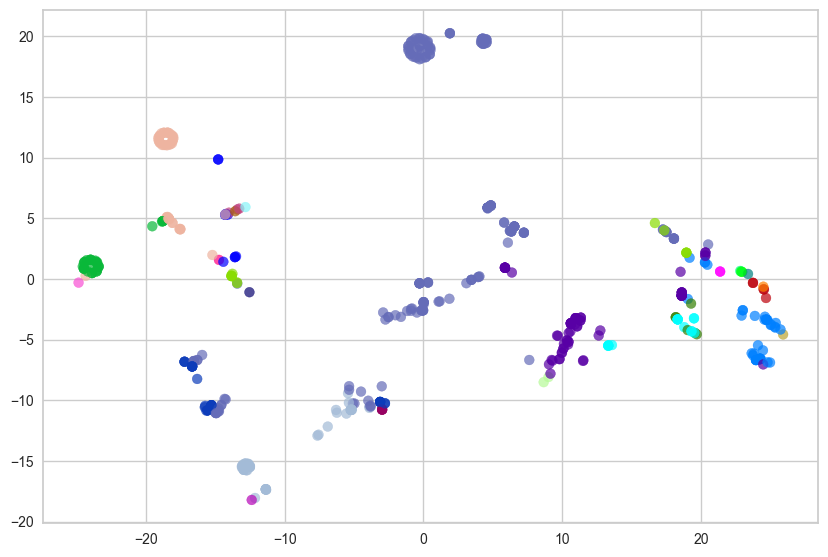

In [29]:
tsne_ref1000 = show_tradeoffs_tsne(ref1000_space, title='')

---
## **Iteration 0 (interactive, 50)**

In [30]:
# Initialize the project/file
it0_50_space = ArchitectureSpaceAnalyzer()
it0_50_space.initialize_dataset(NSGAII_IT0_50_PROJECT_NAME)
print(it0_50_space.PROJECT_NAME)

it0_50_space.set_labels(ALL_CLUSTER_LABELS)
it0_50_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_50_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it0_50_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-0-l-2
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-0-l-2
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [31]:
it0_50_space.objectives_df.head()

,solID,perfQ,reliability,#changes,pas
0,419,0.210716,0.299766,3.28,0.0
1,921,0.153165,0.847111,2.90,2.0
2,1006,0.264819,0.709835,2.90,2.0
3,842,0.209112,0.663923,4.10,1.0
4,761,0.209150,0.726455,3.09,3.0


Statistics for the 4 objectives.

In [32]:
it0_50_space.objectives_df.describe()

,solID,perfQ,reliability,#changes,pas
count,496.000000,496.000000,496.000000,496.000000,496.000000
mean,1078.276210,0.194082,0.642672,3.945887,1.435484
std,413.857554,0.057392,0.191905,2.073667,0.972278
min,19.000000,-0.012006,0.059322,2.900000,0.000000
25%,910.500000,0.153165,0.560012,2.900000,1.000000
50%,1270.500000,0.198819,0.671386,3.090000,1.000000
75%,1381.250000,0.216204,0.791122,3.280000,2.000000
max,1465.000000,0.289480,0.847111,13.920000,5.000000


In [33]:
#it0_50_space.refactions_df.head()

### *Metrics* - Not need to analyze them in this dataset

In [34]:
ref50_it0_pf = it0_50_space.get_pareto_front()
#ref50_it0_norm_pf = it0_50_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it0_dict = it0_50_space.compute_all_metrics(ref_point=(1,1,1,1), reference_front=ref1000_norm_pf)
metrics50_it0_dict['point'] = 'it-0'
print("Pareto front metrics for the 4 objectives")
print(metrics50_it0_dict)

ref50_it0_pf.head()

Pareto front metrics for the 4 objectives
{'C_AB': 0.30845771144278605, 'C_BA': 0.14049586776859505, 'IGDPlus': 0.2604983175224401, 'HV': 0.8622703812180694, 'NPS': 121, 'NSolutions': 144, 'NSequences': 459, 'DE': 0.3293392747565592, 'point': 'it-0'}


,perfQ,reliability,#changes,pas
0,0.209824,0.665843,3.28,0.0
1,0.209112,0.663923,3.28,0.0
2,0.175115,0.669219,3.28,0.0
3,0.121860,0.705059,3.28,0.0
4,0.162572,0.663923,3.28,0.0


### *Clustering*
Only for the purpose of showing the centroid chosen for Iteration 1

In [35]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_50_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it0_50_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [4 3 2 0 3 4 0 4 3 0 0 0 4 3 0 4 4 1 3 2 1 0 1 1 0 1 0 0 2 4 3 1 3 1 2 4 0
 1 1 4 3 0 1 1 4 2 3 4 2 3 2 2 2 3 0 0 2 0 0 2 2 0 3 0 2 3 2 2 3 0 3 2 0 2
 0 3 2 0 3 0 2 0 3 1 0 3 1 0 3 0 2 3 0 3 0 0 2 3 0 2 0 3 0 3 2 2 0 3 0 3 0
 0 3 4 1 2 1 0 3 4 4 1 0 1 0 3 4 3 1 3 4 2 1 1 0 3 1 3 4 1 1 2 0 0 1 3 2 4
 0 1 4 3 4 3 4 1 1 0 2 3 3 2 2 2 2 0 0 3 0 3 0 0 2 3 0 0 3 1 2 2 1 2 3 3 0
 0 2 2 0 3 3 0 3 2 4 4 3 0 2 0 2 3 3 3 3 0 0 2 3 1 2 1 0 3 4 4 1 0 3 0 3 2
 3 3 3 1 4 2 0 1 3 1 0 1 3 4 1 0 3 0 3 3 2 4 0 3 4 2 0 0 0 2 0 0 0 0 2 3 4
 0 4 3 1 0 3 0 2 3 4 0 0 0 3 2 2 0 1 0 2 3 1 0 2 0 3 0 2 3 3 1 4 0 3 1 4 3
 0 0 0 0 2 1 3 4 2 2 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 2 3 0 1 0 0 1 3 2 2 0 0
 0 0 3 2 4 3 4 1 3 3 4 1 1 0 3 3 2 4 3 2 3 0 1 3 1 3 0 0 2 0 2 3 0 3 0 0 3
 1 3 0 2 0 1 1 0 3 2 0 3 1 0 3 2 4 0 1 4 3 4 0 4 2 3 4 4 2 0 3 3 4 1 4 1 3
 0 1 0 0 0 0 1 1 3 2 3 1 4 3 1 0 0 4 3 0 2 1 0 0 4 2 3 1 0 3 4 1 3 4 2 3 2
 3 0 4 3 2 0 2 3 2 0 3 0 3 0 0 2 0 3 3 3 3 3 0 0 3 0 0 

,perfQ,reliability,#changes,pas,cluster,label
197,0.133346,0.670789,3.28,1.0,0,very-slow / reliable / very-few / very-few
17,0.264819,0.560012,8.65,2.0,1,slow / average / very-few / very-few
304,0.265742,0.580264,3.09,2.0,2,slow / average / very-few / very-few
223,0.205996,0.788695,2.90,2.0,3,slow / reliable / very-few / very-few
258,0.208608,0.302645,3.28,0.0,4,slow / minimally-reliable / very-few / very-few


In [36]:
#it0_50_space.show_petal_plot(labels=True, size=(20,5))

This is the **first centroid (258)** chosen as a decision point for the next rounds of search.

In [37]:
centroid_series = it0_50_space.tagged_objectives_df.loc[258]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==1334]
centroid_rows

perfQ                                                 0.208608
reliability                                           0.302645
#changes                                                  3.28
pas                                                        0.0
cluster                                                      4
label          slow / minimally-reliable / very-few / very-few
solID                                                     1334
Name: 258, dtype: object


,perfQ,reliability,#changes,pas,cluster,label,solID
258,0.208608,0.302645,3.28,0.0,4,slow / minimally-reliable / very-few / very-few,1334


This is the **second centroid (223)** chosen as a decision point for the next rounds of search.

In [38]:
centroid_series = it0_50_space.tagged_objectives_df.loc[223]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==584]
centroid_rows

perfQ                                       0.205996
reliability                                 0.788695
#changes                                         2.9
pas                                              2.0
cluster                                            3
label          slow / reliable / very-few / very-few
solID                                            584
Name: 223, dtype: object


,perfQ,reliability,#changes,pas,cluster,label,solID
223,0.205996,0.788695,2.9,2.0,3,slow / reliable / very-few / very-few,584


In [39]:
it0_50_space.show_objective_space()

Configuring (real) cluster centroids as prototypes ... [6, 114, 2, 167, 7]


alt.HConcatChart(...)

In [40]:
it0_50_space.clusters_info()

  cluster 0 : 146 items 29.44 % very-slow / reliable / very-few / very-few
  cluster 3 : 145 items 29.23 % slow / reliable / very-few / very-few
  cluster 2 : 87 items 17.54 % slow / average / very-few / very-few
  cluster 1 : 65 items 13.10 % slow / average / very-few / very-few
  cluster 4 : 53 items 10.69 % slow / minimally-reliable / very-few / very-few


In [41]:
it0_50_space.describe_cluster_labels()

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


,objective,min,max,unit,label
0,perfQ,-0.10,0.14,unit,very-slow
1,perfQ,0.14,0.38,unit,slow
2,perfQ,0.38,0.62,unit,average
3,perfQ,0.62,0.86,unit,fast
4,perfQ,0.86,1.10,unit,very-fast
5,#changes,2.40,11.94,unit,very-few
6,#changes,11.94,21.48,unit,few
7,#changes,21.48,31.02,unit,average
8,#changes,31.02,40.56,unit,some
9,#changes,40.56,50.10,unit,many


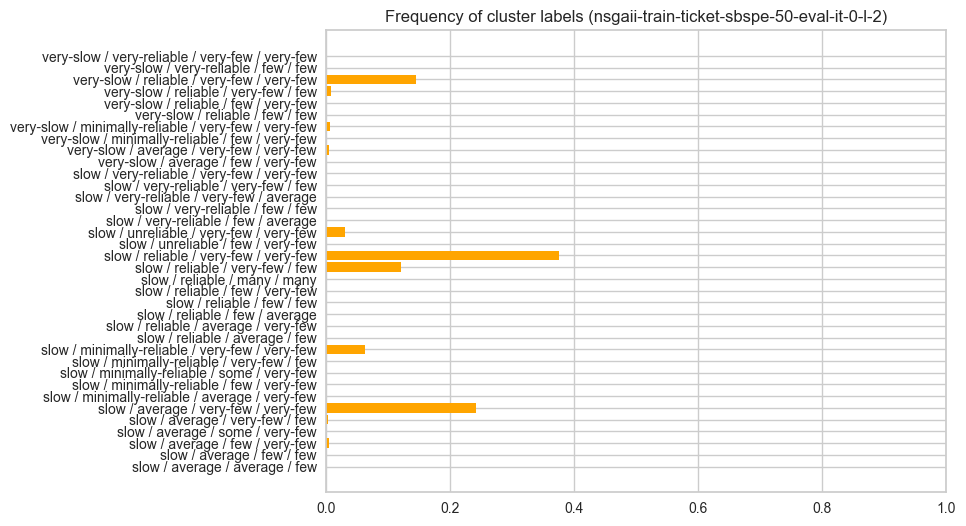

{'slow / average / average / few': 0.0,
 'slow / average / few / few': 0.0,
 'slow / average / few / very-few': 0.004032258064516129,
 'slow / average / some / very-few': 0.0,
 'slow / average / very-few / few': 0.0020161290322580645,
 'slow / average / very-few / very-few': 0.24193548387096775,
 'slow / minimally-reliable / average / very-few': 0.0,
 'slow / minimally-reliable / few / very-few': 0.0,
 'slow / minimally-reliable / some / very-few': 0.0,
 'slow / minimally-reliable / very-few / few': 0.0,
 'slow / minimally-reliable / very-few / very-few': 0.0625,
 'slow / reliable / average / few': 0.0,
 'slow / reliable / average / very-few': 0.0,
 'slow / reliable / few / average': 0.0,
 'slow / reliable / few / few': 0.0,
 'slow / reliable / few / very-few': 0.0,
 'slow / reliable / many / many': 0.0,
 'slow / reliable / very-few / few': 0.12096774193548387,
 'slow / reliable / very-few / very-few': 0.375,
 'slow / unreliable / few / very-few': 0.0,
 'slow / unreliable / very-few / 

In [42]:
it0_50_space.show_cluster_labels_distribution(size=(8,6))

### *Visualizations (density)*

Reusing PCA transformation ...
PCA components: 2 [0.48259393 0.27438249]


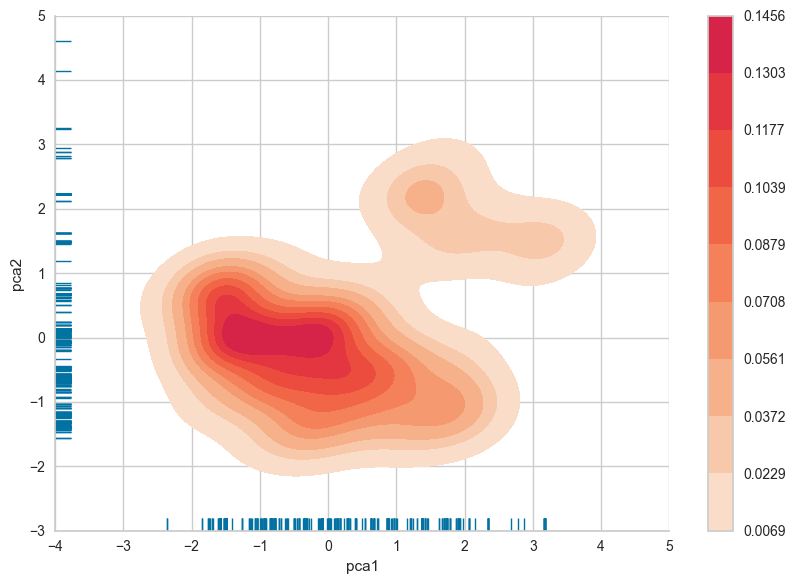

In [43]:
# Density plots for the 2D space of changes versus pas
it0_50_space.show_density_plot(normalize=False, bins=10, pca=pca_ref1000, title='', xlim=(-4,5), ylim=(-3,5), vminmax=(0.004,0.29)) 
#it0_50_space.show_density_plot(kind='bins', normalize=True, bins=10)

In [44]:
# Entropy of 4D space
de_4D = it0_50_space.compute_density_entropy(normalize=True, bins=5)
print("The density entropy is:", de_4D)

The density entropy is: 0.3256228774772127


Reusing PCA
4 features ['perfQ', 'reliability', '#changes', 'pas']
11 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:688: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



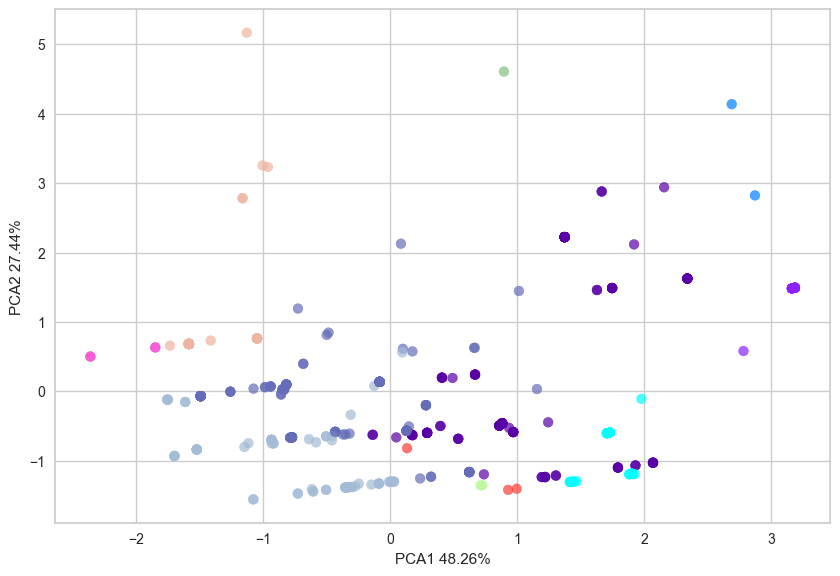

PCA(n_components=2)

In [45]:
show_tradeoffs_pca(it0_50_space, pca=pca_ref1000, title='')

Reusing t-SNE
4 features ['perfQ', 'reliability', '#changes', 'pas']
11 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:655: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



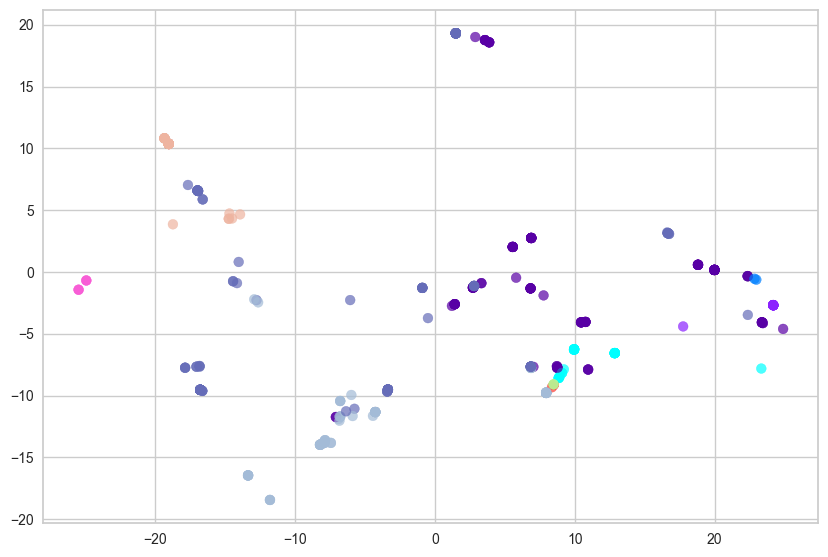

In [46]:
_ = show_tradeoffs_tsne(it0_50_space, title='', tsne=tsne_ref1000)

---
## **Iteration 1: Centroid 258 (interactive, 50)**
This centroid choice is about *slow* perfQ [0.2] and *minimally-reliable* reliability [0.3]. It also involves very few changes and pas.

In [47]:
# Initialize the project/file
it1_50_c258_space = ArchitectureSpaceAnalyzer()
it1_50_c258_space.initialize_dataset(NSGAII_IT1_50_C258_PROJECT_NAME)
print(it1_50_c258_space.PROJECT_NAME)

it1_50_c258_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c258_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c258_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c258_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [48]:
it1_50_c258_space.objectives_df.head()

,solID,perfQ,reliability,#changes,pas
0,207,0.168745,0.661981,6.18,2.0
1,577,0.266925,0.294967,6.56,0.0
2,653,0.266856,0.482953,6.18,2.0
3,981,0.266925,0.294967,6.56,0.0
4,1330,0.149889,0.298885,6.56,0.0


Statistics for the 4 objectives.

In [49]:
it1_50_c258_space.objectives_df.describe()

,solID,perfQ,reliability,#changes,pas
count,496.000000,496.000000,496.000000,496.000000,496.000000
mean,972.687500,0.206146,0.543045,6.570302,1.320565
std,462.689181,0.043017,0.162051,1.654663,0.903450
min,3.000000,0.048499,0.065320,6.180000,0.000000
25%,586.250000,0.168940,0.430005,6.180000,1.000000
50%,1192.000000,0.208608,0.526591,6.180000,1.000000
75%,1365.250000,0.222805,0.661981,6.370000,2.000000
max,1455.000000,0.267466,0.848089,25.310000,5.000000


In [50]:
#it1_50_c258_space.refactions_df.head()

### *Metrics*

In [51]:
ref50_it1_c258_pf = it1_50_c258_space.get_pareto_front()
#ref50_it1_c258_norm_pf = it1_50_c258_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c258_dict = it1_50_c258_space.compute_all_metrics(ref_point=(1,1,1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c258_dict['point'] = 'it1-c258'
print("Pareto front metrics for the 4 objectives")
print(metrics50_it1_c258_dict)

ref50_it1_c258_pf.head()

Pareto front metrics for the 4 objectives
{'C_AB': 0.4129353233830846, 'C_BA': 0.2903225806451613, 'IGDPlus': 0.2003518026619937, 'HV': 0.8384627206251616, 'NPS': 93, 'NSolutions': 103, 'NSequences': 445, 'DE': 0.2759696348334229, 'point': 'it1-c258'}


,perfQ,reliability,#changes,pas
0,0.266984,0.534818,6.37,0.0
1,0.267396,0.528629,6.37,0.0
2,0.207247,0.727459,6.56,0.0
3,0.238048,0.467349,6.37,0.0
4,0.238048,0.463969,6.37,0.0


In [52]:
complete_pf_it1_50_c258_ = ref50_it1_c258_pf.merge(it1_50_c258_space.objectives_df, on=it1_50_c258_space.ALL_OBJECTIVES)
complete_pf_it1_50_c258_ = complete_pf_it1_50_c258_.drop_duplicates(subset=it1_50_c258_space.ALL_OBJECTIVES)
print(complete_pf_it1_50_c258_.shape)
#complete_pf.to_csv('it1_50_c317_pf.csv', index=False)
complete_pf_it1_50_c258_.head()

(93, 5)


,perfQ,reliability,#changes,pas,solID
0,0.266984,0.534818,6.37,0.0,444
3,0.267396,0.528629,6.37,0.0,400
8,0.207247,0.727459,6.56,0.0,1325
9,0.238048,0.467349,6.37,0.0,1108
14,0.238048,0.463969,6.37,0.0,1194


### *Clustering*
This is not strictly needed for the RQ, but it is for computing the scatter plot below.

In [53]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c258_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it1_50_c258_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [4 0 3 0 0 3 3 1 1 4 1 3 3 0 4 1 0 4 3 0 0 1 4 4 4 1 1 0 1 3 3 0 4 3 0 0 0
 4 0 1 1 3 3 1 0 0 4 1 1 0 3 1 4 3 2 1 1 1 1 0 4 4 4 3 3 1 0 3 1 2 3 3 4 1
 0 3 1 1 1 4 3 0 4 4 1 4 1 4 1 1 3 3 0 1 1 1 3 0 4 2 0 0 4 1 1 1 3 3 1 4 1
 1 0 3 0 4 4 0 0 1 1 3 3 4 1 0 0 3 3 4 0 4 0 1 1 1 3 3 1 4 1 1 1 3 1 3 0 3
 3 4 0 1 1 3 0 1 0 4 1 1 4 0 0 3 0 4 4 4 4 1 1 0 3 4 0 1 3 0 4 0 1 4 4 4 3
 4 0 1 1 3 1 4 3 4 3 0 1 4 0 4 4 1 0 1 1 1 3 3 4 3 0 0 4 1 1 4 3 3 1 3 4 1
 4 3 0 4 3 0 0 4 0 2 3 1 0 1 1 0 0 3 3 4 0 3 0 0 4 1 1 0 3 3 0 0 0 0 3 1 2
 3 2 0 4 1 1 1 4 3 3 1 4 1 4 0 0 3 4 1 4 1 4 0 3 3 1 4 4 4 1 3 0 1 4 1 1 3
 3 1 4 3 4 4 4 1 4 0 4 3 0 3 1 3 1 1 0 1 4 1 3 4 0 3 1 1 0 4 1 1 4 3 3 4 3
 1 4 4 0 4 3 0 4 3 0 1 1 3 3 3 4 3 3 3 4 0 3 0 4 1 3 1 3 4 3 1 4 4 4 1 4 0
 3 4 0 0 1 1 3 3 0 1 0 0 4 1 0 3 4 1 3 4 4 1 4 3 1 4 4 3 1 4 1 1 2 0 0 2 1
 2 0 1 1 1 2 2 1 1 3 4 0 4 0 0 1 1 1 1 0 1 0 4 3 4 0 4 3 3 4 1 1 1 3 1 0 4
 1 3 4 4 0 3 4 1 0 2 4 1 2 4 1 4 1 3 4 4 3 3 1 1 4 2 3 

,perfQ,reliability,#changes,pas,cluster,label
146,0.216836,0.309634,6.56,0.0,0,slow / minimally-reliable / very-few / very-few
159,0.206970,0.537210,6.37,1.0,1,slow / average / very-few / very-few
453,0.138222,0.722230,15.17,2.0,2,very-slow / reliable / few / very-few
2,0.266856,0.482953,6.18,2.0,3,slow / average / very-few / very-few
0,0.168745,0.661981,6.18,2.0,4,slow / reliable / very-few / very-few


In [54]:
it1_50_c258_space.show_objective_space()
#it1_50_c258_space.show_petal_plot(labels=True, size=(20,5))

Configuring (real) cluster centroids as prototypes ... [274, 363, 456, 346, 52]


alt.HConcatChart(...)

In [55]:
it1_50_c258_space.clusters_info()

  cluster 1 : 150 items 30.24 % slow / average / very-few / very-few
  cluster 4 : 121 items 24.40 % slow / reliable / very-few / very-few
  cluster 3 : 112 items 22.58 % slow / average / very-few / very-few
  cluster 0 : 99 items 19.96 % slow / minimally-reliable / very-few / very-few
  cluster 2 : 14 items 2.82 % very-slow / reliable / few / very-few


In [56]:
it1_50_c258_space.describe_cluster_labels()

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


,objective,min,max,unit,label
0,perfQ,-0.10,0.14,unit,very-slow
1,perfQ,0.14,0.38,unit,slow
2,perfQ,0.38,0.62,unit,average
3,perfQ,0.62,0.86,unit,fast
4,perfQ,0.86,1.10,unit,very-fast
5,#changes,2.40,11.94,unit,very-few
6,#changes,11.94,21.48,unit,few
7,#changes,21.48,31.02,unit,average
8,#changes,31.02,40.56,unit,some
9,#changes,40.56,50.10,unit,many


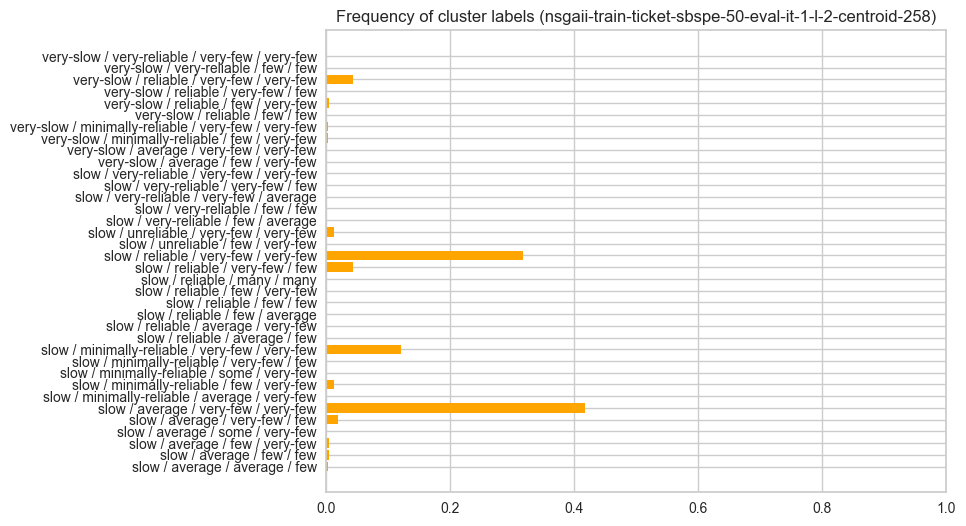

{'slow / average / average / few': 0.0020161290322580645,
 'slow / average / few / few': 0.004032258064516129,
 'slow / average / few / very-few': 0.004032258064516129,
 'slow / average / some / very-few': 0.0,
 'slow / average / very-few / few': 0.018145161290322582,
 'slow / average / very-few / very-few': 0.4173387096774194,
 'slow / minimally-reliable / average / very-few': 0.0,
 'slow / minimally-reliable / few / very-few': 0.012096774193548387,
 'slow / minimally-reliable / some / very-few': 0.0,
 'slow / minimally-reliable / very-few / few': 0.0,
 'slow / minimally-reliable / very-few / very-few': 0.12096774193548387,
 'slow / reliable / average / few': 0.0,
 'slow / reliable / average / very-few': 0.0,
 'slow / reliable / few / average': 0.0,
 'slow / reliable / few / few': 0.0,
 'slow / reliable / few / very-few': 0.0,
 'slow / reliable / many / many': 0.0,
 'slow / reliable / very-few / few': 0.04233870967741935,
 'slow / reliable / very-few / very-few': 0.3165322580645161,
 

In [57]:
it1_50_c258_space.show_cluster_labels_distribution(size=(8,6))

### *Visualizations (density)*

In [58]:
# Entropy of 4D space
de_4D = it1_50_c258_space.compute_density_entropy(normalize=True, bins=5)
print("The density entropy is:", de_4D)

The density entropy is: 0.26795502617898287


Reusing PCA transformation ...
PCA components: 2 [0.48259393 0.27438249]


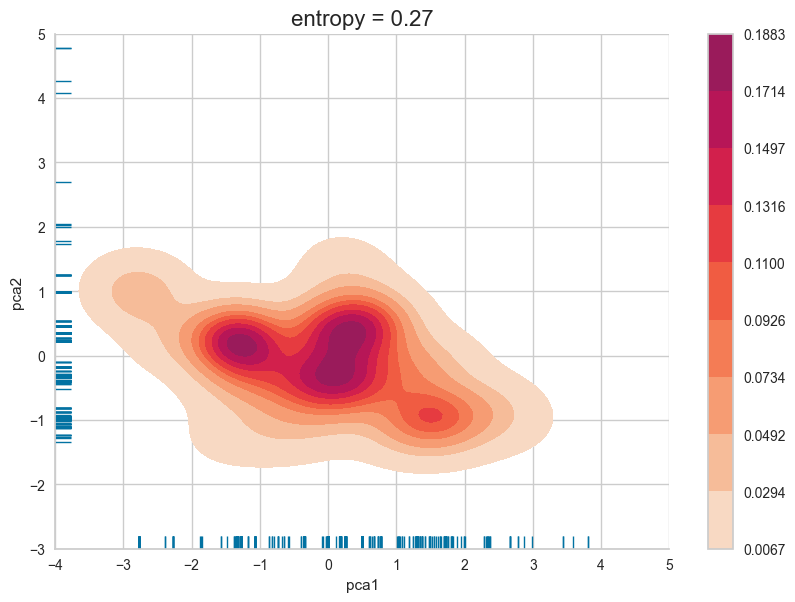

In [59]:
# Density plots for the 2D space of changes versus pas
e_label = f'entropy = {de_4D:.2f}'
it1_50_c258_space.show_density_plot(normalize=False, bins=10, pca=pca_ref1000, title=e_label, xlim=(-4,5), ylim=(-3,5), vminmax=(0.004,0.29))
#it1_50_c258_space.show_density_plot(kind='bins', normalize=True, bins=10)

Reusing PCA
4 features ['perfQ', 'reliability', '#changes', 'pas']
14 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:688: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



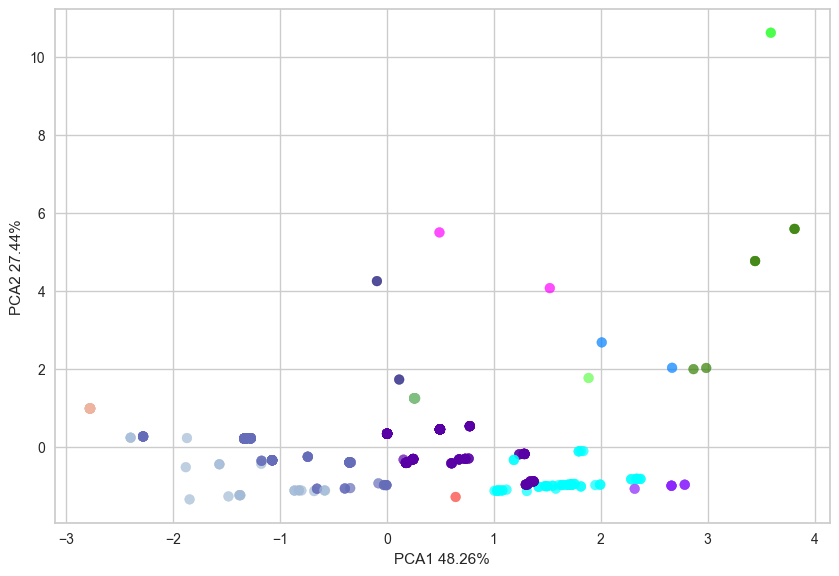

PCA(n_components=2)

In [60]:
show_tradeoffs_pca(it1_50_c258_space, pca=pca_ref1000, title='')

Reusing t-SNE
4 features ['perfQ', 'reliability', '#changes', 'pas']
14 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:655: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



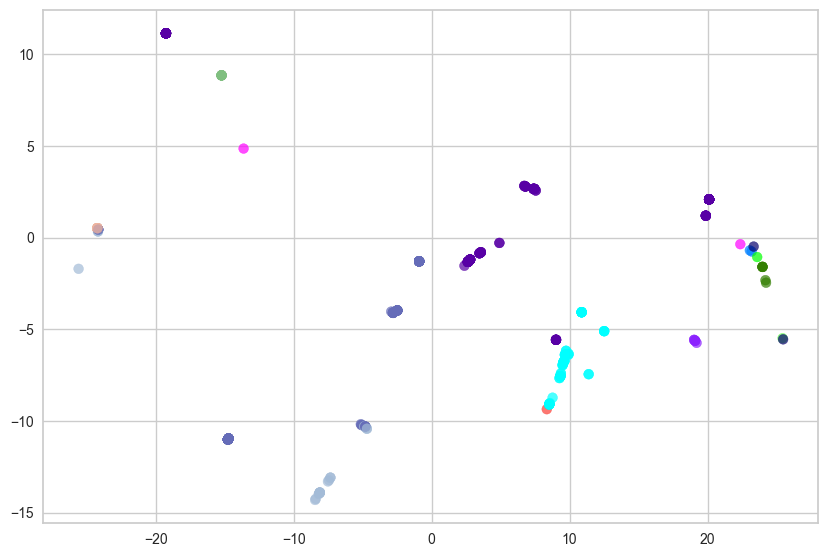

In [61]:
_ = show_tradeoffs_tsne(it1_50_c258_space, title='', tsne=tsne_ref1000)

---
## **Iteration 1: Centroid 223 (interactive, 50)**
This centroid choice is about *slow* perfQ [0.2] and *reliable* reliability [0.79]. It also involves very few changes and pas.

In [62]:
# Initialize the project/file
it1_50_c223_space = ArchitectureSpaceAnalyzer()
it1_50_c223_space.initialize_dataset(NSGAII_IT1_50_C223_PROJECT_NAME)
print(it1_50_c223_space.PROJECT_NAME)

it1_50_c223_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c223_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c223_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c223_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [63]:
it1_50_c223_space.objectives_df.head()

,solID,perfQ,reliability,#changes,pas
0,609,0.206919,0.659124,4.54,2.0
1,804,0.235470,0.432430,5.99,1.0
2,1370,0.233279,0.432747,6.18,4.0
3,1402,0.178755,0.847808,5.99,1.0
4,1179,0.233279,0.432747,6.18,4.0


Statistics for perfQ and reliability objectives.

In [64]:
it1_50_c223_space.objectives_df.describe()

,solID,perfQ,reliability,#changes,pas
count,496.000000,496.000000,496.000000,496.000000,496.000000
mean,1037.028226,0.207280,0.732535,6.069940,1.645161
std,430.569601,0.034271,0.129930,0.836774,0.751495
min,8.000000,0.056311,0.202066,4.350000,0.000000
25%,756.250000,0.205996,0.660925,5.990000,1.000000
50%,1238.500000,0.208680,0.784135,5.990000,2.000000
75%,1367.250000,0.211184,0.844112,5.990000,2.000000
max,1444.000000,0.267708,0.872976,14.130000,4.000000


In [65]:
#it1_50_c223_space.refactions_df

### *Metrics*

In [66]:
ref50_it1_c223_pf = it1_50_c223_space.get_pareto_front()
#ref50_it1_c223_norm_pf = it1_50_c223_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c223_dict = it1_50_c223_space.compute_all_metrics(ref_point=(1,1,1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c223_dict['point'] = 'it1-c223'
print("Pareto front metrics for the 4 objectives:")
print(metrics50_it1_c223_dict)

ref50_it1_c223_pf.head()

Pareto front metrics for the 4 objectives:
{'C_AB': 0.1044776119402985, 'C_BA': 0.11458333333333333, 'IGDPlus': 0.42559042765687466, 'HV': 0.8018072624599912, 'NPS': 96, 'NSolutions': 126, 'NSequences': 457, 'DE': 0.272277792857358, 'point': 'it1-c223'}


,perfQ,reliability,#changes,pas
0,0.209824,0.665843,4.54,1.0
1,0.124782,0.666803,4.54,1.0
2,0.267708,0.662344,6.18,0.0
3,0.263069,0.658015,6.18,0.0
4,0.239737,0.593187,6.18,0.0


In [67]:
complete_pf_it1_50_c223 = ref50_it1_c223_pf.merge(it1_50_c223_space.objectives_df, on=it1_50_c223_space.ALL_OBJECTIVES)
complete_pf_it1_50_c223 = complete_pf_it1_50_c223.drop_duplicates(subset=it1_50_c223_space.ALL_OBJECTIVES)
print(complete_pf_it1_50_c223.shape)
#complete_pf.to_csv('it1_50_c317_pf.csv', index=False)
complete_pf_it1_50_c223.head()

(96, 5)


,perfQ,reliability,#changes,pas,solID
0,0.209824,0.665843,4.54,1.0,45
6,0.124782,0.666803,4.54,1.0,1376
7,0.267708,0.662344,6.18,0.0,942
9,0.263069,0.658015,6.18,0.0,958
19,0.239737,0.593187,6.18,0.0,1008


### *Clustering*

In [68]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c223_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it1_50_c223_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [0 1 0 4 0 0 0 0 0 4 0 0 4 0 0 0 0 0 1 3 0 3 1 3 0 0 0 1 3 3 1 0 4 0 0 0 0
 4 3 3 4 0 3 3 3 0 3 3 0 0 1 0 1 0 4 4 0 0 0 4 0 4 4 4 1 0 0 4 1 1 4 3 4 0
 3 4 4 0 3 3 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 4 0 0 2 0 4 0 0 4 0 0 4 4 4
 0 1 0 0 1 0 4 0 0 1 1 4 4 4 4 4 0 0 0 1 0 4 4 4 1 0 0 4 0 4 0 0 4 0 0 1 0
 4 0 4 4 0 0 4 4 4 4 0 4 0 0 1 0 0 1 1 1 4 0 1 1 4 4 4 4 0 0 1 0 1 4 1 4 0
 4 0 4 4 0 4 4 0 0 1 0 2 4 0 0 0 4 4 0 4 4 0 4 0 0 1 1 4 0 0 0 4 0 4 4 4 4
 0 0 1 1 0 0 0 0 1 4 1 0 4 0 0 0 0 0 1 0 1 0 3 2 1 3 2 3 0 4 1 0 4 4 0 0 4
 0 0 4 4 0 0 4 0 0 0 0 4 4 0 0 1 1 1 0 3 1 3 4 4 4 4 0 4 1 0 0 1 4 4 1 0 3
 4 1 1 3 4 4 4 0 0 1 0 1 1 0 4 4 4 4 0 0 4 4 0 4 1 0 0 4 0 1 0 1 1 0 4 4 4
 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 1 1 3 0 0 1 0 1 4 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 3 4 0 0 3 4 4 0 0 4 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 4 4 4 0 4 4 0 1 0 4 2 3 1 4 0 1 1 3
 4 4 0 4 0 1 0 0 1 0 0 0 4 4 0 4 0 0 4 0 4 1 0 0 2 1 3 

,perfQ,reliability,#changes,pas,cluster,label
65,0.205996,0.842550,5.80,2.0,0,slow / reliable / very-few / very-few
50,0.241374,0.535955,5.99,1.0,1,slow / average / very-few / very-few
100,0.056472,0.848388,11.79,3.0,2,very-slow / reliable / very-few / few
278,0.118818,0.792661,5.99,1.0,3,very-slow / reliable / very-few / very-few
395,0.191184,0.727041,6.18,1.0,4,slow / reliable / very-few / very-few


In [69]:
it1_50_c223_space.show_objective_space()
#it1_50_c223_space.show_petal_plot(labels=True, size=(20,5))

Configuring (real) cluster centroids as prototypes ... [87, 52, 100, 249, 291]


alt.HConcatChart(...)

In [70]:
it1_50_c223_space.clusters_info()

  cluster 0 : 249 items 50.20 % slow / reliable / very-few / very-few
  cluster 4 : 131 items 26.41 % slow / reliable / very-few / very-few
  cluster 1 : 78 items 15.73 % slow / average / very-few / very-few
  cluster 3 : 31 items 6.25 % very-slow / reliable / very-few / very-few
  cluster 2 : 7 items 1.41 % very-slow / reliable / very-few / few


In [71]:
it1_50_c223_space.describe_cluster_labels()

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


,objective,min,max,unit,label
0,perfQ,-0.10,0.14,unit,very-slow
1,perfQ,0.14,0.38,unit,slow
2,perfQ,0.38,0.62,unit,average
3,perfQ,0.62,0.86,unit,fast
4,perfQ,0.86,1.10,unit,very-fast
5,#changes,2.40,11.94,unit,very-few
6,#changes,11.94,21.48,unit,few
7,#changes,21.48,31.02,unit,average
8,#changes,31.02,40.56,unit,some
9,#changes,40.56,50.10,unit,many


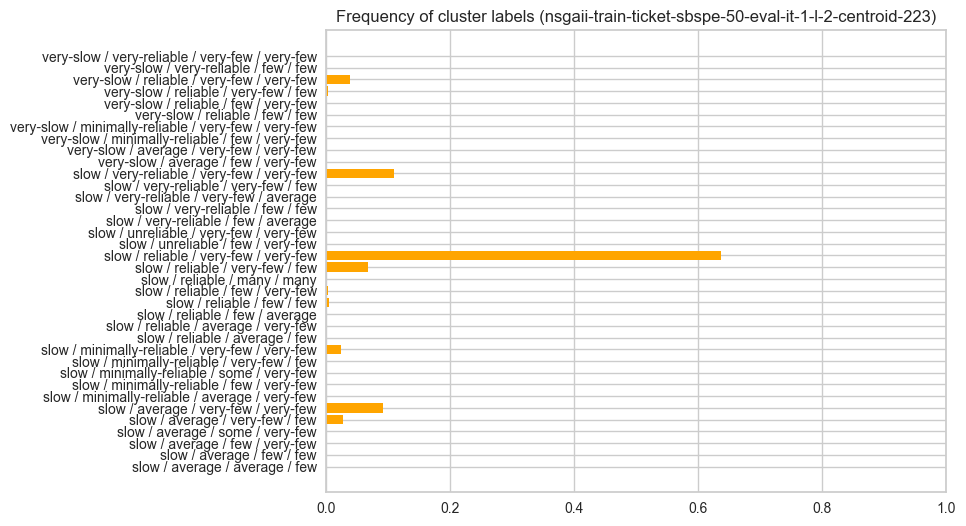

{'slow / average / average / few': 0.0,
 'slow / average / few / few': 0.0,
 'slow / average / few / very-few': 0.0,
 'slow / average / some / very-few': 0.0,
 'slow / average / very-few / few': 0.02620967741935484,
 'slow / average / very-few / very-few': 0.0907258064516129,
 'slow / minimally-reliable / average / very-few': 0.0,
 'slow / minimally-reliable / few / very-few': 0.0,
 'slow / minimally-reliable / some / very-few': 0.0,
 'slow / minimally-reliable / very-few / few': 0.0,
 'slow / minimally-reliable / very-few / very-few': 0.024193548387096774,
 'slow / reliable / average / few': 0.0,
 'slow / reliable / average / very-few': 0.0,
 'slow / reliable / few / average': 0.0,
 'slow / reliable / few / few': 0.004032258064516129,
 'slow / reliable / few / very-few': 0.0020161290322580645,
 'slow / reliable / many / many': 0.0,
 'slow / reliable / very-few / few': 0.06653225806451613,
 'slow / reliable / very-few / very-few': 0.6370967741935484,
 'slow / unreliable / few / very-fe

In [72]:
it1_50_c223_space.show_cluster_labels_distribution(size=(8,6))

### *Visuallizations (density)*

In [73]:
# Entropy of 4D space
de_4D = it1_50_c223_space.compute_density_entropy(normalize=True, bins=5)
print("The density entropy is:", de_4D)

The density entropy is: 0.26533413101888365


Reusing PCA transformation ...
PCA components: 2 [0.48259393 0.27438249]


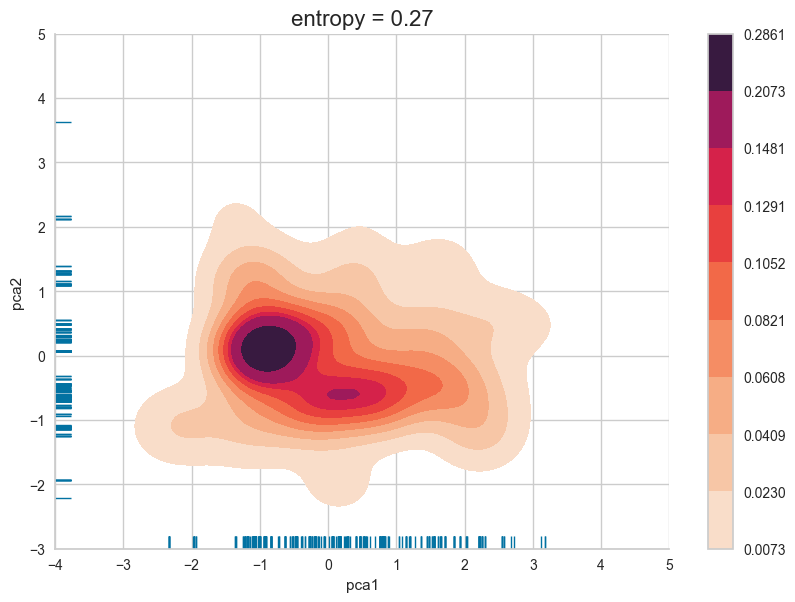

In [74]:
# Density plots for the 2D space of changes versus pas
e_label = f'entropy = {de_4D:.2f}'
it1_50_c223_space.show_density_plot(normalize=False, bins=10, pca=pca_ref1000, title=e_label, xlim=(-4,5), ylim=(-3,5), vminmax=(0.004,0.29)) 
#it1_50_c223_space.show_density_plot(kind='bins', normalize=True, bins=10)

Reusing PCA
4 features ['perfQ', 'reliability', '#changes', 'pas']
10 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:688: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



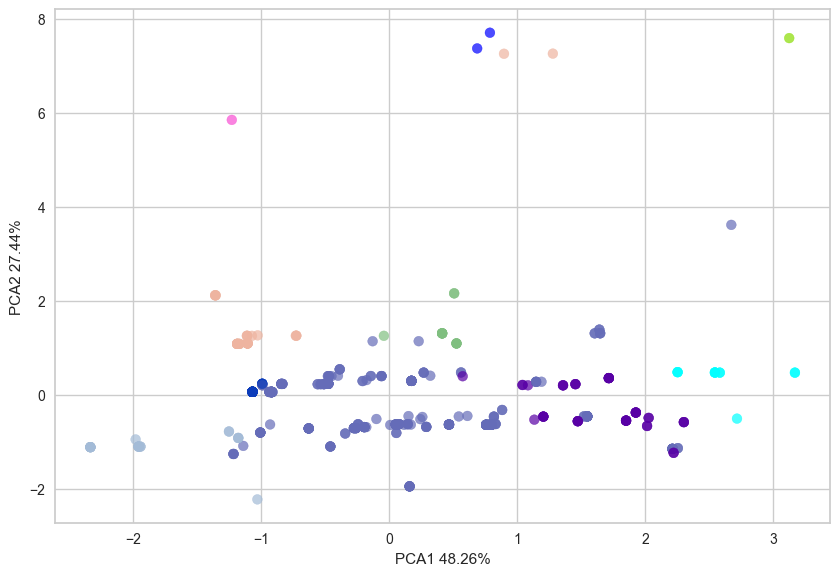

PCA(n_components=2)

In [75]:
show_tradeoffs_pca(it1_50_c223_space, pca=pca_ref1000, title='')

Reusing t-SNE
4 features ['perfQ', 'reliability', '#changes', 'pas']
10 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:655: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



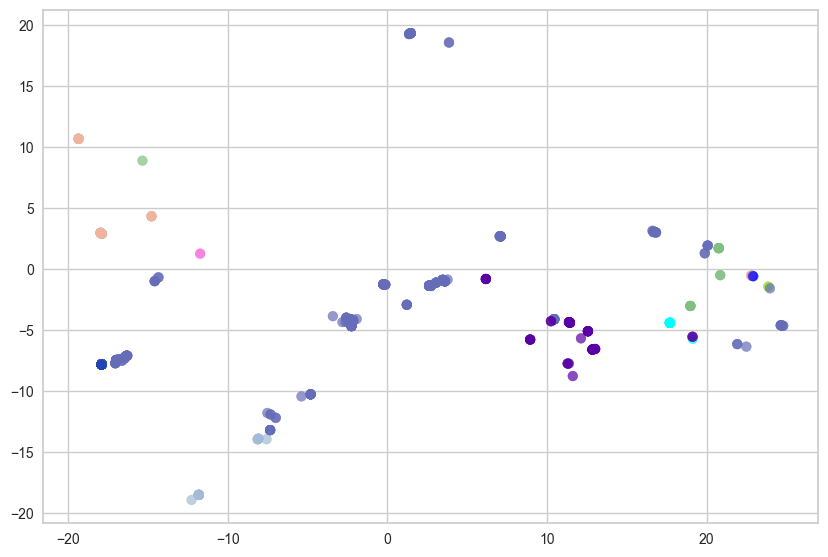

In [76]:
_ = show_tradeoffs_tsne(it1_50_c223_space, title='', tsne=tsne_ref1000)

---
## **Iteration 0 (non-interactive, 100)**

In [77]:
# Initialize the project/file
it0_100_space = ArchitectureSpaceAnalyzer()
it0_100_space.initialize_dataset(NSGAII_IT0_100_PROJECT_NAME)
print(it0_100_space.PROJECT_NAME)

it0_100_space.set_labels(ALL_CLUSTER_LABELS)
it0_100_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_100_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = it0_100_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-100-eval-it-0
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-100-eval-it-0
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [78]:
it0_100_space.objectives_df.head()

,solID,perfQ,reliability,#changes,pas
0,289,0.145989,0.872976,5.80,3.0
1,1221,0.183599,0.465675,6.18,0.0
2,1265,0.323642,0.779689,9.75,2.0
3,1459,0.264819,0.779689,5.80,2.0
4,2081,0.065988,0.792661,5.99,1.0


Statistics for the 4 objectives.

In [79]:
it0_100_space.objectives_df.describe()

,solID,perfQ,reliability,#changes,pas
count,495.000000,495.000000,495.000000,495.000000,495.000000
mean,2026.509091,0.216254,0.764558,7.067737,2.090909
std,764.437511,0.074065,0.155361,2.913605,1.084403
min,4.000000,-0.003535,0.063643,5.800000,0.000000
25%,1533.500000,0.153165,0.780015,5.800000,1.000000
50%,2269.000000,0.211697,0.837592,5.990000,2.000000
75%,2693.000000,0.269642,0.846598,6.180000,3.000000
max,2883.000000,0.350950,0.893732,32.800000,7.000000


In [80]:
#it0_100_space.refactions_df.head()

### *Metrics*

In [81]:
ref100_it0_pf = it0_100_space.get_pareto_front()
#ref100_it0_norm_pf = it0_100_space.compute_pareto_front(invert_max=True, objectives=objs_changes_pas)

# The reference front is the ref1000 space
metrics100_it0_dict = it0_100_space.compute_all_metrics(ref_point=(1,1,1,1), reference_front=ref1000_norm_pf)
metrics100_it0_dict['point'] = 'it-01-baseline'
print("Pareto front metrics for the 4 objectives:")
print(metrics100_it0_dict)

ref100_it0_pf.head()

Pareto front metrics for the 4 objectives:
{'C_AB': 0.19402985074626866, 'C_BA': 0.09655172413793103, 'IGDPlus': 0.27225229497574654, 'HV': 0.8517439312019969, 'NPS': 145, 'NSolutions': 184, 'NSequences': 473, 'DE': 0.3524330411333432, 'point': 'it-01-baseline'}


,perfQ,reliability,#changes,pas
0,0.183599,0.465675,6.18,0.0
1,0.311566,0.780015,5.99,1.0
2,0.311566,0.780015,5.99,1.0
3,0.255149,0.783278,5.99,1.0
4,0.153165,0.872976,5.99,1.0


### *Clustering*
This is not strictly needed for the RQ, but it is for computing the scatter plot below.

In [82]:
# Try k-Means
#labels, _, silhouette = it0_100_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_100_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it0_100_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [0 4 1 0 0 2 3 1 3 4 1 1 4 4 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 3 4 0 1 3
 0 2 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 2 1 0 0 0 0 1 0 0 1 0 1 0 2 0 0 0 0 1
 0 0 0 0 0 0 0 1 1 4 0 0 2 3 3 1 0 4 3 1 4 4 4 0 1 4 1 0 0 0 0 1 1 4 0 0 0
 0 0 3 4 0 0 2 2 3 0 1 3 4 3 0 0 4 3 1 1 3 0 3 3 3 2 0 2 0 2 4 3 1 1 0 4 4
 0 0 0 4 4 0 4 0 0 0 1 4 1 0 0 4 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 4 0 4 2 0 4 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 4 0 1 2 0 0 0 0 0 4 4 0 0 0 0 3 1 4 1 4 0 0 0 4 4 0 4 1 4 0 0 1 0 4
 3 4 0 2 0 0 0 3 4 0 0 4 1 1 4 0 2 0 2 1 0 4 1 0 0 0 1 4 1 0 1 4 4 0 0 0 0
 4 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 2 1 0 1 0 4 0 0 0 1 0
 0 0 1 1 0 2 0 0 2 0 0 1 0 0 0 0 0 0 4 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 4
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 4
 0 4 0 1 0 0 0 0 0 1 0 4 0 0 4 0 0 4 0 0 0 4 0 0 1 0 0 4 0 0 4 0 0 0 0 1 0
 0 0 0 4 0 1 0 2 4 2 2 0 2 1 1 0 0 0 0 1 0 1 1 0 1 0 0 

,perfQ,reliability,#changes,pas,cluster,label
85,0.180473,0.847111,5.99,2.0,0,slow / reliable / very-few / very-few
289,0.326796,0.781316,5.99,2.0,1,slow / reliable / very-few / very-few
117,0.198819,0.842037,14.03,5.0,2,slow / reliable / few / few
142,0.270234,0.214906,13.89,1.0,3,slow / minimally-reliable / few / very-few
248,0.157413,0.487494,6.18,1.0,4,slow / average / very-few / very-few


In [83]:
it0_100_space.show_objective_space()
#it0_100_space.show_petal_plot(labels=True, size=(20,5))

Configuring (real) cluster centroids as prototypes ... [115, 305, 138, 87, 225]


alt.HConcatChart(...)

In [84]:
it0_100_space.clusters_info()

  cluster 0 : 295 items 59.60 % slow / reliable / very-few / very-few
  cluster 1 : 95 items 19.19 % slow / reliable / very-few / very-few
  cluster 4 : 62 items 12.53 % slow / average / very-few / very-few
  cluster 2 : 23 items 4.65 % slow / reliable / few / few
  cluster 3 : 20 items 4.04 % slow / minimally-reliable / few / very-few


In [85]:
it0_100_space.describe_cluster_labels()

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


,objective,min,max,unit,label
0,perfQ,-0.10,0.14,unit,very-slow
1,perfQ,0.14,0.38,unit,slow
2,perfQ,0.38,0.62,unit,average
3,perfQ,0.62,0.86,unit,fast
4,perfQ,0.86,1.10,unit,very-fast
5,#changes,2.40,11.94,unit,very-few
6,#changes,11.94,21.48,unit,few
7,#changes,21.48,31.02,unit,average
8,#changes,31.02,40.56,unit,some
9,#changes,40.56,50.10,unit,many


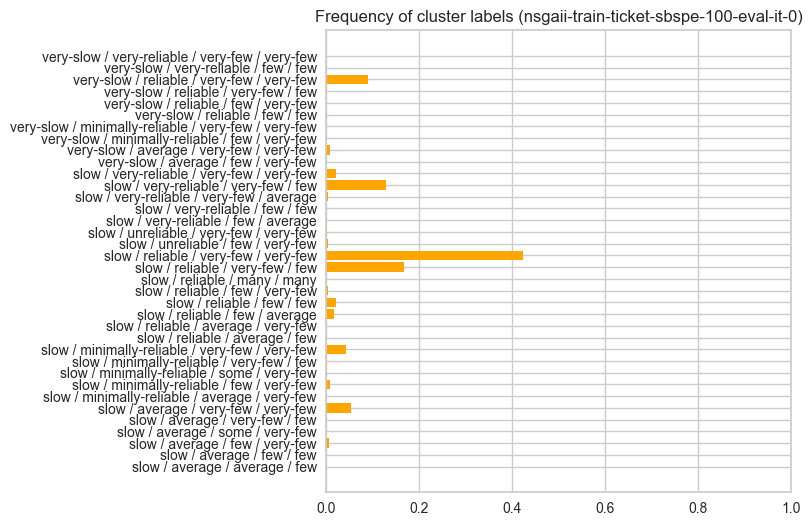

{'slow / average / average / few': 0.0,
 'slow / average / few / few': 0.0,
 'slow / average / few / very-few': 0.006060606060606061,
 'slow / average / some / very-few': 0.0,
 'slow / average / very-few / few': 0.0,
 'slow / average / very-few / very-few': 0.052525252525252523,
 'slow / minimally-reliable / average / very-few': 0.0,
 'slow / minimally-reliable / few / very-few': 0.00808080808080808,
 'slow / minimally-reliable / some / very-few': 0.00202020202020202,
 'slow / minimally-reliable / very-few / few': 0.00202020202020202,
 'slow / minimally-reliable / very-few / very-few': 0.04242424242424243,
 'slow / reliable / average / few': 0.0,
 'slow / reliable / average / very-few': 0.0,
 'slow / reliable / few / average': 0.01616161616161616,
 'slow / reliable / few / few': 0.020202020202020204,
 'slow / reliable / few / very-few': 0.00404040404040404,
 'slow / reliable / many / many': 0.0,
 'slow / reliable / very-few / few': 0.16565656565656567,
 'slow / reliable / very-few / ve

In [86]:
it0_100_space.show_cluster_labels_distribution(size=(6,6))

### *Visualizations (density)*

In [87]:
# Entropy of 4D space
de_4D = it0_100_space.compute_density_entropy(normalize=True, bins=5)
print("The density entropy is:", de_4D)

The density entropy is: 0.36168869533760084


Reusing PCA transformation ...
PCA components: 2 [0.48259393 0.27438249]


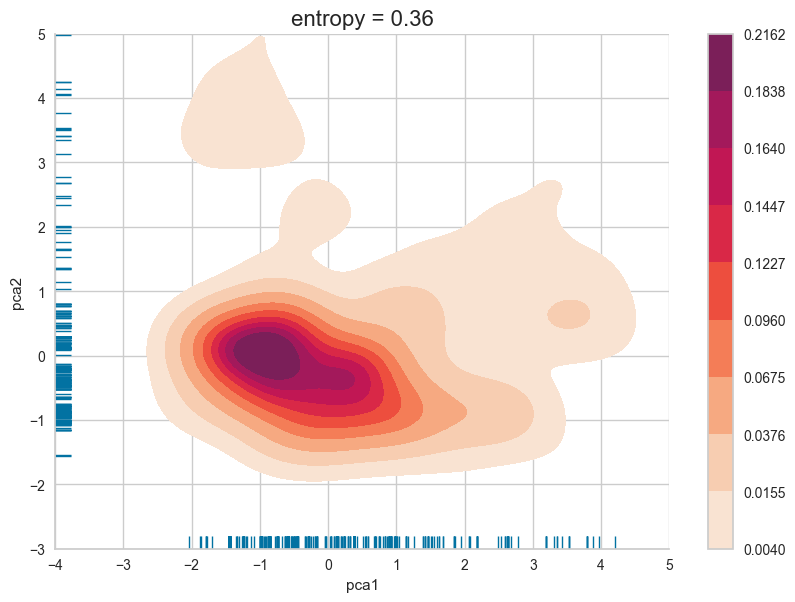

In [88]:
# Density plots for the 2D space of changes versus pas
e_label = f'entropy = {de_4D:.2f}'
it0_100_space.show_density_plot(normalize=False, bins=10, pca=pca_ref1000, title=e_label, xlim=(-4,5), ylim=(-3,5), vminmax=(0.004,0.29)) 
#it0_100_space.show_density_plot(kind='bins', normalize=True, bins=10)

Reusing PCA
4 features ['perfQ', 'reliability', '#changes', 'pas']
20 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:688: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



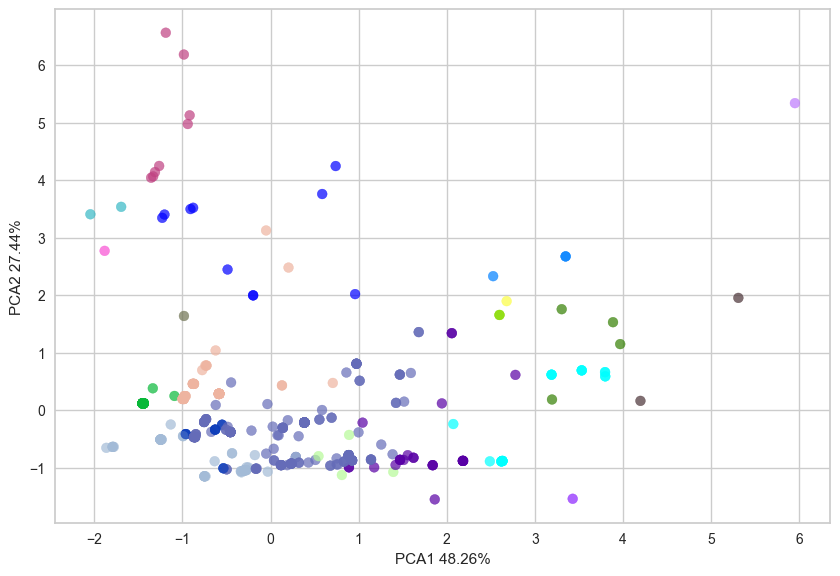

PCA(n_components=2)

In [89]:
show_tradeoffs_pca(it0_100_space, pca=pca_ref1000, title='')

Reusing t-SNE
4 features ['perfQ', 'reliability', '#changes', 'pas']
20 clusters


/Users/adiazpace/Documents/my-research/optimization/interactive-kit/architecturespaceanalyzer.py:655: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



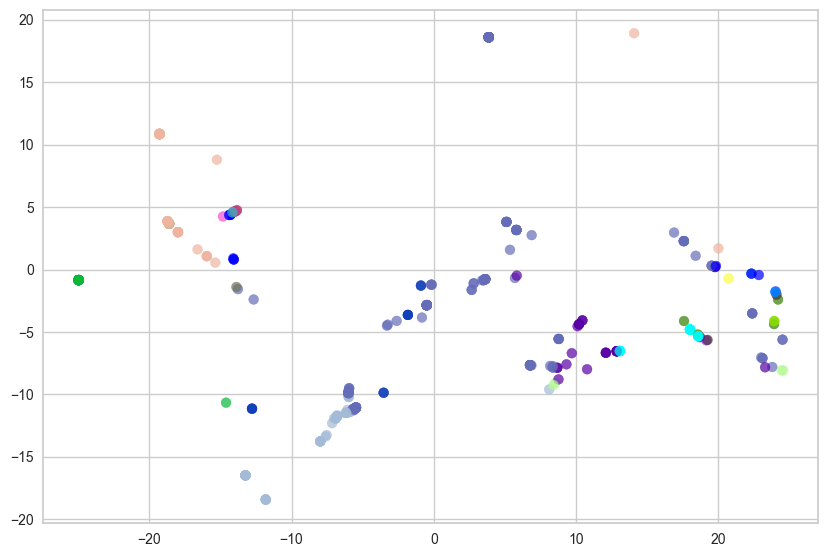

In [90]:
_ = show_tradeoffs_tsne(it0_100_space, title='', tsne=tsne_ref1000)

---

## **Misc**

### *Comparison of Metrics*

In [91]:
# Concatenation of all the metrics
s1 = pd.DataFrame([metrics1000_dict])
#s2 = pd.DataFrame([metrics50_it0_dict])
s3 = pd.DataFrame([metrics50_it1_c258_dict])
s4 = pd.DataFrame([metrics50_it1_c223_dict])
s5 = pd.DataFrame([metrics100_it0_dict])
metrics_df = pd.concat([s1, s3, s4, s5])
metrics_df

,C_AB,C_BA,IGDPlus,HV,NPS,NSolutions,NSequences,DE,point
0,0.820896,0.208955,0.185644,0.881731,201,249,492,0.410450,reference
0,0.412935,0.290323,0.200352,0.838463,93,103,445,0.275970,it1-c258
0,0.104478,0.114583,0.425590,0.801807,96,126,457,0.272278,it1-c223
0,0.194030,0.096552,0.272252,0.851744,145,184,473,0.352433,it-01-baseline


In [92]:
#dfi.export(metrics_df,'table.png', table_conversion = 'matplotlib')
#Image.open('table.png')

In [93]:
# Looking at the different cluster labels from all the spaces
a = set(ref1000_space.CLUSTER_LABELS.values())
b = set(it0_50_space.CLUSTER_LABELS.values())
c = set(it1_50_c258_space.CLUSTER_LABELS.values())
d = set(it1_50_c223_space.CLUSTER_LABELS.values())
e = set(it0_100_space.CLUSTER_LABELS.values())

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
ALL_CLUSTER_LABELS = list(ALL_CLUSTER_LABELS)

10


In [94]:
a = set(ref1000_space.tagged_objectives_df['label'])
b = set(it0_50_space.tagged_objectives_df['label'])
c = set(it1_50_c258_space.tagged_objectives_df['label'])
d = set(it1_50_c223_space.tagged_objectives_df['label'])
e = set(it0_100_space.tagged_objectives_df['label'])

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
ALL_CLUSTER_LABELS = list(ALL_CLUSTER_LABELS)
ALL_CLUSTER_LABELS

36


['slow / reliable / few / average',
 'slow / reliable / few / very-few',
 'slow / average / some / very-few',
 'very-slow / reliable / very-few / few',
 'slow / very-reliable / very-few / average',
 'very-slow / reliable / few / few',
 'slow / reliable / very-few / very-few',
 'slow / minimally-reliable / very-few / few',
 'very-slow / minimally-reliable / very-few / very-few',
 'slow / very-reliable / few / few',
 'slow / very-reliable / very-few / few',
 'very-slow / reliable / few / very-few',
 'slow / minimally-reliable / average / very-few',
 'slow / average / few / few',
 'slow / reliable / very-few / few',
 'very-slow / reliable / very-few / very-few',
 'very-slow / average / few / very-few',
 'slow / average / very-few / few',
 'very-slow / minimally-reliable / few / very-few',
 'very-slow / average / very-few / very-few',
 'slow / unreliable / few / very-few',
 'slow / average / few / very-few',
 'slow / minimally-reliable / few / very-few',
 'very-slow / very-reliable / very-

---

# **REFACTORING ACTIONS**

In [95]:
it0_50_space.ALL_REFACTORINGS

{'Move_Operation_Component', 'Move_Operation_New_Component_New_Node'}

Updating refactoring actions for intermediate-50

In [96]:
refactions_args = {
    'Move_Component_New_Node': 1,
    'Move_Operation_Component': 2,
    'Move_Operation_New_Component_New_Node': 1,
    'UMLCloneNode': 1
}

_, it0_50_updated_refactions_df = it0_50_space.read_file_batch(1,31, length=2, arguments=refactions_args, option='refactions')
print(it0_50_updated_refactions_df.shape)
it0_50_updated_refactions_df.head()

Reading files ... 1 31 refactions
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.
(496, 3)


,solID,op1,op2
0,419,"Move_Operation_Component(rebook,Sso)","Move_Operation_Component(findAll,Login)"
1,921,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(modify)
2,1006,Move_Operation_New_Component_New_Node(login),Move_Operation_New_Component_New_Node(findAll)
3,842,UMLCloneNode(container-sso),"Move_Operation_Component(findAll,Login)"
4,761,"Move_Operation_Component(generate,Order-other)",Move_Operation_New_Component_New_Node(findAll)


In [97]:
# centroid 258 --> solID = 1334
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 1334]
# Move_Operation_Component(modify)	Move_Operation_Component(rebook)

,solID,op1,op2
258,1334,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)"


In [98]:
# centroid 223 --> solID = 584 (cluster 3)
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 584]
# Move_Operation_New_Component_New_Node(findAll,New-Component_uckvimuprr)	Move_Operation_New_Component_New_Node(findall,New-Component_vsytcmjsan)

,solID,op1,op2
223,584,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll)


Updating refactoring actions for centroid-258

In [99]:
refactions_args = {
    'Move_Component_New_Node': 1,
    'Move_Operation_Component': 2,
    'Move_Operation_New_Component_New_Node': 1,
    'UMLCloneNode': 1
}

_, it1_50_c258_updated_refactions_df = it1_50_c258_space.read_file_batch(1,31, length=2, arguments=refactions_args, option='refactions')
print(it1_50_c258_updated_refactions_df.shape)
it1_50_c258_updated_refactions_df.head()

Reading files ... 1 31 refactions
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.
(496, 3)


,solID,op1,op2
0,207,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(rebook)
1,577,"Move_Operation_Component(modify,Sso)","Move_Operation_Component(findAll,Verification)"
2,653,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(modify)
3,981,"Move_Operation_Component(findAll,Verification)","Move_Operation_Component(modify,Sso)"
4,1330,"Move_Operation_Component(updateUser,Seat)","Move_Operation_Component(modify,Sso)"


In [100]:
prefix_sequence_centroid258 = ['Move_Operation_Component(modify,Rebook)',	'Move_Operation_Component(rebook,Sso)']
it1_50_c258_updated_refactions_df = it1_50_c258_space.add_sequence_prefix(prefix_sequence_centroid258)
it1_50_c258_updated_refactions_df

,solID,op1,op2,op3,op4
0,207,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(rebook)
1,577,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(modify,Sso)","Move_Operation_Component(findAll,Verification)"
2,653,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(modify)
3,981,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(findAll,Verification)","Move_Operation_Component(modify,Sso)"
4,1330,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(updateUser,Seat)","Move_Operation_Component(modify,Sso)"
...,...,...,...,...,...
491,1312,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(getByID),Move_Operation_New_Component_New_Node(updateUser)
492,799,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(getByID,Admin-user)","Move_Operation_Component(updateUser,Login)"
493,1145,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(updateUser,Seat)","Move_Operation_Component(getByID,Admin-user)"
494,1330,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(rebook,Rebook)"


In [101]:
# Merging the 2 files (after removing duplicates)
complete_pf_it1_50_c258_ = complete_pf_it1_50_c258_.drop_duplicates(subset='solID') # Removing duplicate
print(complete_pf_it1_50_c258_.shape)
it1_50_c258_updated_refactions_df = it1_50_c258_updated_refactions_df.drop_duplicates(subset='solID') # Removing duplicates
print(it1_50_c258_updated_refactions_df.shape)

(89, 5)
(373, 5)


In [102]:
merged_df = complete_pf_it1_50_c258_.merge(it1_50_c258_updated_refactions_df, on='solID')
merged_df.to_csv('merged-'+it1_50_c258_space.PROJECT_NAME+'.csv', index=False)
merged_df

,perfQ,reliability,#changes,pas,solID,op1,op2,op3,op4
0,0.266984,0.534818,6.37,0.0,444,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(updateUser)
1,0.267396,0.528629,6.37,0.0,400,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(getByID),"Move_Operation_Component(modify,Order-other)"
2,0.207247,0.727459,6.56,0.0,1325,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(getByID,Admin-user)","Move_Operation_Component(generate,Sso)"
3,0.238048,0.467349,6.37,0.0,1108,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(generate,Order-other)",Move_Operation_New_Component_New_Node(getByID)
4,0.238048,0.463969,6.37,0.0,1194,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(verify,Order-other)",Move_Operation_New_Component_New_Node(getByID)
...,...,...,...,...,...,...,...,...,...
84,0.266857,0.425073,6.37,3.0,1016,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(rebook,Rebook)","Move_Operation_Component(updateUser,Order-other)"
85,0.267396,0.528629,12.74,0.0,1399,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(getByID),"Move_Operation_Component(modify,Order-other)"
86,0.207153,0.308341,13.12,0.0,1426,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)",Move_Operation_New_Component_New_Node(modify),Move_Operation_New_Component_New_Node(findAll)
87,0.195573,0.306006,13.12,0.0,1082,"Move_Operation_Component(modify,Rebook)","Move_Operation_Component(rebook,Sso)","Move_Operation_Component(updateUser,Login)","Move_Operation_Component(generate,Verification)"


Updating refactoring actions for centroid-223

In [103]:
refactions_args = {
    'Move_Component_New_Node': 1,
    'Move_Operation_Component': 2,
    'Move_Operation_New_Component_New_Node': 1,
    'UMLCloneNode': 1
}

_, it1_50_c223_updated_refactions_df = it1_50_c223_space.read_file_batch(1,31, length=2, arguments=refactions_args, option='refactions')
print(it1_50_c223_updated_refactions_df.shape)
it1_50_c223_updated_refactions_df

Reading files ... 1 31 refactions
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.
(496, 3)


,solID,op1,op2
0,609,"Move_Operation_Component(findAll,Verification)",Move_Component_New_Node(New-Component_uckvimuprr)
1,804,"Move_Operation_Component(login,Order-other)",Move_Operation_New_Component_New_Node(getByID)
2,1370,"Move_Operation_Component(findAll,Verification)","Move_Operation_Component(login,Order-other)"
3,1402,"Move_Operation_Component(updateUser,Login)",Move_Operation_New_Component_New_Node(modify)
4,1179,"Move_Operation_Component(findAll,Verification)","Move_Operation_Component(login,Order-other)"
...,...,...,...
491,1189,Move_Operation_New_Component_New_Node(generate),"Move_Operation_Component(login,Order-other)"
492,1256,"Move_Operation_Component(generate,New-Componen...",Move_Operation_New_Component_New_Node(modify)
493,1005,"Move_Operation_Component(verify,New-Component_...","Move_Operation_Component(login,Order-other)"
494,1392,Move_Operation_New_Component_New_Node(verify),"Move_Operation_Component(login,New-Component_u..."


In [104]:
prefix_sequence_centroid223 = ['Move_Operation_New_Component_New_Node(findAll)',	'Move_Operation_New_Component_New_Node(findAll)']
it1_50_c223_updated_refactions_df = it1_50_c223_space.add_sequence_prefix(prefix_sequence_centroid223)
it1_50_c223_updated_refactions_df

,solID,op1,op2,op3,op4
0,609,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(findAll,Verification)",Move_Component_New_Node(New-Component_uckvimuprr)
1,804,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(login,Order-other)",Move_Operation_New_Component_New_Node(getByID)
2,1370,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(findAll,Verification)","Move_Operation_Component(login,Order-other)"
3,1402,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(updateUser,Login)",Move_Operation_New_Component_New_Node(modify)
4,1179,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(findAll,Verification)","Move_Operation_Component(login,Order-other)"
...,...,...,...,...,...
491,1189,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(generate),"Move_Operation_Component(login,Order-other)"
492,1256,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(generate,New-Componen...",Move_Operation_New_Component_New_Node(modify)
493,1005,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(verify,New-Component_...","Move_Operation_Component(login,Order-other)"
494,1392,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(verify),"Move_Operation_Component(login,New-Component_u..."


In [105]:
# Merging the 2 files (after removing duplicates)
complete_pf_it1_50_c223 = complete_pf_it1_50_c223.drop_duplicates(subset='solID') # Removing duplicate
print(complete_pf_it1_50_c223.shape)
it1_50_c223_updated_refactions_df = it1_50_c223_updated_refactions_df.drop_duplicates(subset='solID') # Removing duplicates
print(it1_50_c223_updated_refactions_df.shape)

(89, 5)
(356, 5)


In [106]:
merged_df = complete_pf_it1_50_c223.merge(it1_50_c223_updated_refactions_df, on='solID')
merged_df.to_csv('merged-'+it1_50_c223_space.PROJECT_NAME+'.csv', index=False)
merged_df

,perfQ,reliability,#changes,pas,solID,op1,op2,op3,op4
0,0.209824,0.665843,4.54,1.0,45,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),Move_Component_New_Node(New-Component_uckvimuprr),"Move_Operation_Component(findAll,Order-other)"
1,0.124782,0.666803,4.54,1.0,1376,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(verify,Order-other)",Move_Operation_New_Component_New_Node(updateUser)
2,0.267708,0.662344,6.18,0.0,942,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(modify,Order-other)","Move_Operation_Component(getByID,New-Component..."
3,0.263069,0.658015,6.18,0.0,958,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(findAll,Order-other)",Move_Operation_New_Component_New_Node(getByID)
4,0.239737,0.593187,6.18,0.0,1008,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(rebook,Order-other)",Move_Operation_New_Component_New_Node(generate)
...,...,...,...,...,...,...,...,...,...
84,0.206027,0.789234,5.99,3.0,1162,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(generate),"Move_Operation_Component(modify,Order-other)"
85,0.206000,0.788377,5.99,3.0,1275,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(modify),"Move_Operation_Component(findAll,Order-other)"
86,0.209150,0.784871,5.99,3.0,253,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(generate,Order-other)",Move_Operation_New_Component_New_Node(modify)
87,0.209150,0.723075,7.00,2.0,1347,Move_Operation_New_Component_New_Node(findAll),Move_Operation_New_Component_New_Node(findAll),"Move_Operation_Component(verify,Order-other)",UMLCloneNode(container-order-other)


---